# Знакомство с pytorch (5 баллов)

In [1]:
import torch
import numpy as np

In [2]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [3]:
# pytorch world

x = np.arange(16).reshape(4, 4)
x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## NumPy vs Pytorch

Numpy и Pytorch не требуют описания статического графа вычислений.

Можно отлаживаться с помощью pdb или просто print.

API несколько различается:

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.int64)
```


Легко конвертировать между собой:

```
torch.from_numpy(npx) -- вернет Tensor
tt.numpy() -- вернет Numpy Array
```

Преобразовать тензор из одного числа в обычное питоновское число:
```
torch.tensor([1]).item() -> 1
```


Если что:
- смотрите документацию https://pytorch.org/docs/
- гуглите (Stackoverflow/tutorials)

Давайте кое что посчитаем

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


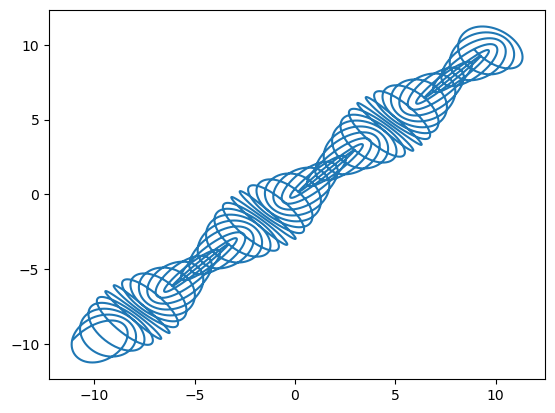

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

t = torch.linspace(-10, 10, steps = 10000)

x = t - 1.5 * torch.cos(15 * t)
y = t - 1.5 * torch.sin(16 * t)

plt.plot(x.numpy(), y.numpy())

# Automatic gradients

У каждого тензора в Pytorch есть флаг `requires_grad`, который отвечает за автоматическое вычисление градиентов:

1. Создать переменную: `a = torch.tensor(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запросить обратный проход `loss.backward()`

4. Градиенты будут доступны в `a.grads`


Есть два важных отличия Pytorch от Theano/TF:

1. Функцию ошибки можно изменять динамически, например на каждом минибатче.

2. После вычисления `.backward()` градиенты сохраняются в `.grad` каждой задействованной переменной, при повторных вызовах градиенты суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать batch_size. Поэтому, после каждого шага оптимизатора градиенты стоит обнулять.



## Leaf vs Non-leaf Variable:
```
x = torch.tensor([1., 2., 3., 4.], requires_grad=True))  # leaf tensor
y = x + 1  # not a leaf variable
```

Градиенты будут сохранены и доступны для использования только для `leaf tensor`.
Такое поведение по-умолчанию сделано ради экономии памяти. Все тензоры с флагом `requires_grad = False` считаются`leaf tensors` по умолчанию.


Обратите внимание, что вычисление градиентов работает только для тензоров с вещественным типом данных:

In [5]:
# will not work
#x = torch.tensor([1, 2, 3, 4], requires_grad=True)


Чтобы выставить флаг `requires_grad=False` и выключить автоматическое вычисление градиентов для нескольких тензоров, можно использовать `with torch.no_grad()` или `detach`:

In [6]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)

w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


Рассмотрим пример линейной регрессии на датасете Boston

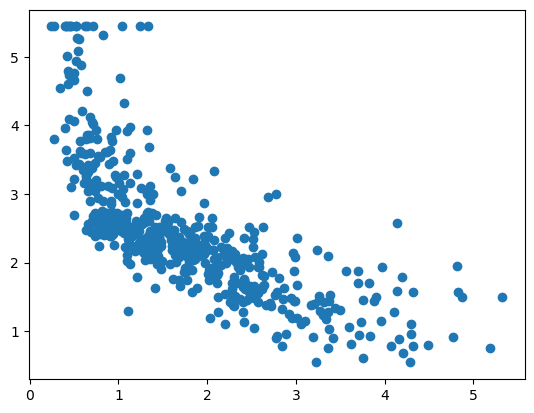

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
x = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

x = x[:, -1] / x[:, -1].std()
y = y / y.std()

plt.scatter(x, y)

In [8]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# все тензоры являются leaf-tensors
# x и y не требуют вычисления градиентов
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

True True
True True
True False
True False


# Линейная регрессия c помощью pytroch

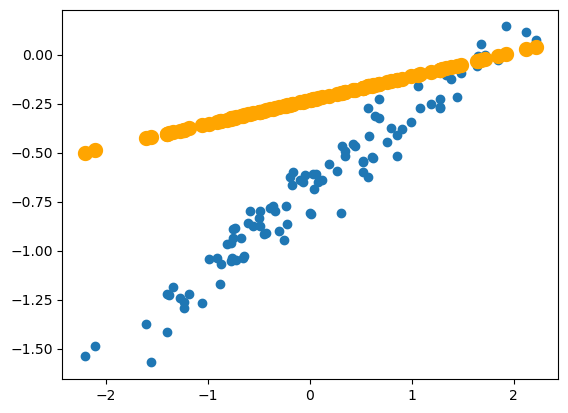

loss =  0.283146
Done!


In [9]:
from IPython.display import clear_output

torch.manual_seed(42)
x = torch.randn(100, 1)
y = 0.4 * x + torch.randn(100, 1) * 0.1 - 0.7

w = torch.tensor([[0.0]], requires_grad=True)
b = torch.tensor([[0.0]], requires_grad=True)

for i in range(1000):

    # Предсказание модели
    y_pred = torch.matmul(x, w) + b

    # Считаем MSE
    loss = torch.mean((y_pred - y)**2)

    # backprop
    loss.backward()

    # вот так руками можно применять градиенты
    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # обнуляем градиенты руками
    w.grad.data.zero_()
    b.grad.data.zero_()

    # строим графики
    if (i+1)%5==0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы удобны в использовании:

- требуется указать список переменных для оптимизации
- `opt.step()` применяет `update` ($U^{n}$) к весам
- `opt.zero_grad()` сбрасывает градиенты





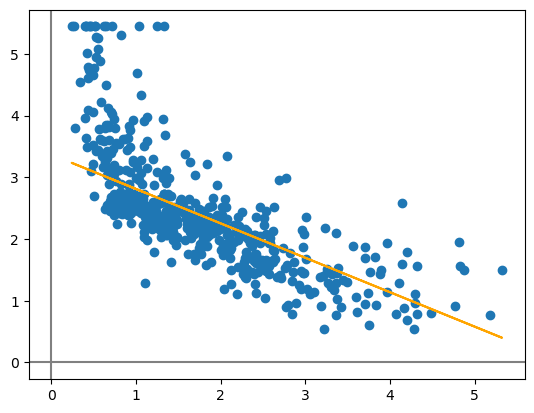

loss =  0.49351760745048523
Done!


In [10]:
import torch
from IPython.display import clear_output

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
x = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(1000):
    y_pred = torch.add(torch.mul(x, w), b)
    loss = torch.mean((y_pred - y) ** 2)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

# Немного более сложных тензоров (2 балла)

$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$

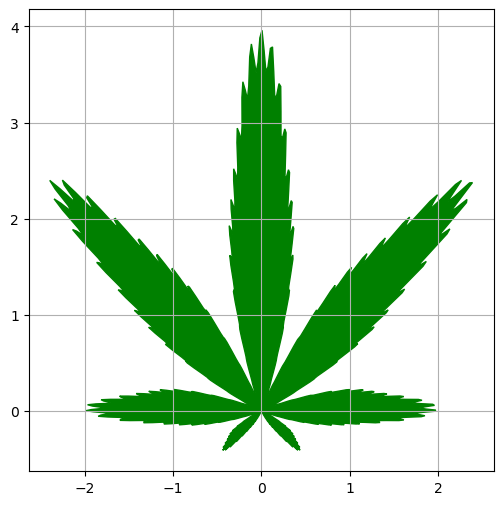

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
theta = torch.linspace(- np.pi, np.pi, steps=1000)

theta = torch.linspace(-np.pi, np.pi, steps=1000)

rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()